In [19]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import json, pymongo, pandas, scipy
import numpy as np

In [3]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
def connect_to_database(): 
    # load credentials to access the database, connect, identify collection
    data = json.load(open('../experiment/.credentials/auth.json'))
    mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
    connection = pymongo.MongoClient(mongo_tunnel)
    data_base = connection['sleep_affect_memory']
    collection = data_base['replication']
    return collection

In [10]:
def identify_workers(collection):
    
    # the second is my worker id
    exclude = ['NONE', 'A33F2FVAMGJDGG']
    all_workers = [i for i in collection.distinct('worker_id') if i not in exclude]
    complete = [] 
    # extract workers who've completed entire experiment -- not returned HIT early
    for i_worker in all_workers: 
        tmp_data = collection.find({'worker_id':i_worker})
        if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
            complete.append(i_worker)
    
    return complete

In [11]:
def extract_data(w_ids): 
    
    # columns to exclude 
    ignore = ['trial_index', 
              'time_elapsed', 
              'stimulus', 
              'correct_response', 
              'internal_node_id', 
              'trial_type']
    
    subject_trial_data = pandas.DataFrame()
    
    # iterate over workers 
    for i_worker in w_ids: 
        
        # extract worker's data from mongo database
        i_data = collection.find({'worker_id':i_worker})

        for one_trial in i_data: 
            
            # extract all data we want 
            if 'worker_feedback' not in one_trial['trial_data'].keys(): 
                q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
                q['subject'] = one_trial['worker_id']
                subject_trial_data = subject_trial_data.append(q, ignore_index=True)
    
    # convert to absolute value of distance
    subject_trial_data.distance = np.abs(subject_trial_data.distance)
    
    return subject_trial_data

In [12]:
collection = connect_to_database()
worker_ids = identify_workers(collection)
trial_data = extract_data(worker_ids)

In [13]:
generalization_data = trial_data[trial_data.stage=='generalization']
generalization_data = generalization_data[generalization_data.valence!='control']

In [14]:
response_mapping = {80:'positive',81:'negative',32:'neutral'}
generalization_data['response'] = [response_mapping[i] for i in generalization_data.key_press.values]
generalization_data['distance'] = abs(generalization_data['distance'])

In [15]:
main_question_conditions = (generalization_data.valence != 'control')
valence_by_distance = generalization_data[main_question_conditions][['response', 'distance', 'valence']]

In [16]:
valence_by_distance[0:10]

,response,distance,valence
33,positive,5.0,positive
34,positive,5.0,positive
35,positive,20.0,positive
36,positive,0.0,negative
37,neutral,20.0,negative
38,negative,5.0,negative
39,positive,20.0,positive
42,neutral,100.0,positive
43,negative,100.0,negative
44,positive,0.0,positive


In [17]:
from statsmodels.formula.api import ols
model = ols("response ~ distance * valence", valence_by_distance).fit()

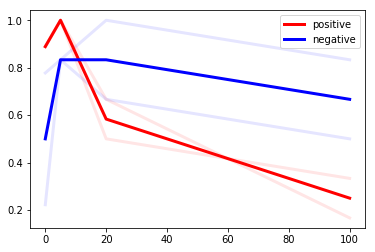

In [20]:
colores = {'positive':'red', 'negative':'blue'}

distances = np.sort(generalization_data.distance.unique())
all_things = {'positive':[], 'negative':[]}

for i_subject in generalization_data.subject.unique(): 
    
    for i_valence in ['positive', 'negative']: 
        
        things = [] 
        
        for i_distance in distances: 
        
            gen = generalization_data[generalization_data.subject==i_subject]
            conditions = (gen.valence==i_valence)*(gen.distance==i_distance)
            things.append(mean(gen.response[conditions] == gen.valence[conditions]))
        
        all_things[i_valence].append(things)
        plot(distances, things, color=colores[i_valence], alpha=.1, linewidth=3)

plot(distances, np.mean(all_things['positive'],0), color='red', linewidth=3, label='positive')
plot(distances, np.mean(all_things['negative'],0), color='blue', linewidth=3, label='negative')
legend() 


In [21]:
def get_pilot_subject(name_of_iteration): 

    # extract worker's data from mongo database
    i_data = collection.find({'iteration_name':name_of_iteration})

    ignore = ['trial_index', 
              'time_elapsed', 
              'stimulus', 
              'correct_response', 
              'internal_node_id', 
              'trial_type']

    person_data = pandas.DataFrame()

    for one_trial in i_data: 

        # extract all data we want 
        if 'worker_feedback' not in one_trial['trial_data'].keys(): 
            
            q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
            q['subject'] = one_trial['worker_id']
            person_data = person_data.append(q, ignore_index=True)
    
    return person_data

In [22]:
def generalization_curves(gen_data, data_type, name): 

    gen_curves = {}
    distances = np.sort(gen_data['distance'].unique())
    colores = {'positive':'red', 'negative':'blue'}

    for i_valence in ['positive', 'negative']: 

        gen_rates = [] 
        gen_sems = []
        
        for i_distance in distances: 

            conditions = (gen_data.valence==i_valence) * (gen_data.distance==i_distance)
            
            if data_type == 'valence': 
                choices = gen_data.response[conditions] == gen_data.valence[conditions]
            elif data_type == 'rt': 
                choices = gen_data.rt[conditions]
                choices = [i for i in choices if i != None]
            
            gen_rates.append(mean(choices))
            gen_sems.append(scipy.stats.sem(choices))
            
        gen_rates = np.array(gen_rates)
        gen_sems = np.array(gen_sems)
        gen_curves[i_valence] = gen_rates
        plot(distances, gen_rates, linewidth=3, label=i_valence, color=colores[i_valence], alpha=.5)
        fill_between(distances, gen_rates+gen_sems, gen_rates-gen_sems, alpha=.2, color=colores[i_valence])
    
    title("%s's pilot data!"%name)
    
    if data_type == 'valence': ylabel('p( association_valence | tone )')
    elif data_type == 'rt': 
        ylabel('Reaction time')
        ylim([0,2000])
    xlabel('Distance from original tone')
    legend()


In [23]:
def preprocess_subject(subject_data): 
    
    subject_gen = subject_data[subject_data.stage=='generalization']
    subject_gen = subject_gen[subject_gen.valence!='control']
    subject_gen['distance'] = np.abs(subject_gen['distance'])
    responses = {80:'positive',81:'negative',32:'neutral',None:None}
    subject_gen['response'] = [responses[i] for i in subject_gen.key_press.values]
    
    return subject_gen

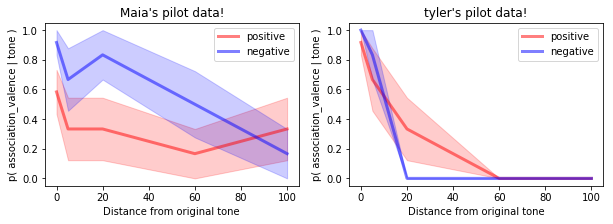

In [25]:
# load Maia's data
maia_data = get_pilot_subject('maia_test',)
# preprocess
maia_g_data = preprocess_subject(maia_data)
# plot generaliation curves
figure(figsize=[10,3])
subplot(121) ; generalization_curves(maia_g_data, 'valence',  "Maia")

# extract tyler's data
tyler_data = get_pilot_subject('tyler_final_pilot')
# preprocess
tyler_g_data = preprocess_subject(tyler_data)
# plot generalization curve
subplot(122); generalization_curves(tyler_g_data, 'valence', "tyler")

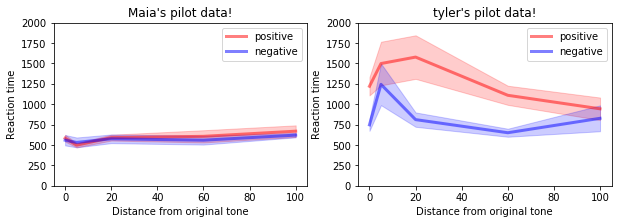

In [26]:
figure(figsize=[10,3])

subplot(121)
generalization_curves(maia_g_data, 'rt', 'Maia')

subplot(122)
generalization_curves(tyler_g_data, 'rt', 'tyler')

In [34]:
import json, pymongo, pandas
import numpy as np
import matplotlib.pyplot as plt 
import warnings; warnings.simplefilter('ignore')
  
auth_path = "/Users/biota/memory/sleep_affect_memory/experiment/.credentials/auth.json"
  
def connect_to_database(): 

    # load credentials to access the database, connect, identify collection
    data = json.load(open(auth_path))
    mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
    connection = pymongo.MongoClient(mongo_tunnel)
    data_base = connection['sleep_affect_memory']
    collection = data_base['replication']
    
    return collection
    
def identify_workers(collection):

    # the second is my worker id
    exclude = ['NONE', 'A33F2FVAMGJDGG']
    all_workers = [i for i in collection.distinct('worker_id') if i not in exclude]
    # extract workers who've completed entire experiment -- not returned HIT early
    complete = [] 
    for i_worker in all_workers: 
        tmp_data = collection.find({'worker_id':i_worker})
        if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
            complete.append(i_worker)
            
    return complete
    
def extract_data(): 

    # connect with mongo
    collection = connect_to_database() 
    # identify workers who completed experiment
    worker_ids = identify_workers(collection)
    # pret to remove worker identifiers 
    subject_ids = {worker_ids[i]:i for i in range(len(worker_ids))}
    # initialize data frame
    subject_trial_data = pandas.DataFrame()
    # iterate over workers 
    for i_worker in worker_ids: 
        # extract worker's data from mongo database
        i_data = collection.find({'worker_id':i_worker})
        # extract trial data
        for one_trial in i_data: 
            # only extract data we want 
            if 'worker_feedback' not in one_trial['trial_data'].keys(): 
                q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys())}
                # use anonymized worker identifier
                q['subject'] = subject_ids[i_worker]
                subject_trial_data = subject_trial_data.append(q, ignore_index=True)
                
    return subject_trial_data
  
# extract and format data from database
data = extract_data()
  
# save for later analysis
data.to_csv('subject_data.csv')